Importa o modelo a ser fatiado e mapeado

In [39]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
First arg: /home/matheus/Downloads/Tangran3/TangranV2/input/stl_models/cubo70.STL
Second arg: 300.0
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/input/sliced
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/slicing-with-images
number of degenerated triangles = 0
eps = 0.004
max thickness = 2
rounded plane spacing spacing = 2
model zmin = 0, model zmax = 20, first plane Z = -1.996, number of planes = 12
-Incremental, cubo70.STL, thickness = 2, #T = 176, #P = 10, #S = 880, 0.000186s (slicing), 0.001667s (polygon assembling), 0.003411s (total), *K: 5


rm: cannot remove '*.svg': No such file or directory
rm: cannot remove '*.png': No such file or directory




writing image: ../input/sliced/layer_000.pgm


writing image: ../input/sliced/layer_001.pgm


writing image: ../input/sliced/layer_002.pgm


writing image: ../input/sliced/layer_003.pgm


writing image: ../input/sliced/layer_004.pgm


writing image: ../input/sliced/layer_005.pgm


writing image: ../input/sliced/layer_006.pgm


writing image: ../input/sliced/layer_007.pgm


writing image: ../input/sliced/layer_008.pgm


writing image: ../input/sliced/layer_009.pgm


writing output file: out_3d.svg
... done


Total de [criando as camadas] : 1.5246808528900146
salvando as camadas
Total de [salvando as camadas] : 0.3321518898010254
Total de [Fase 0: ] : 1.857332468032837


Paredes Finas

In [40]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO: anotar todos os (não fechou contorno)
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.00011181831359863281
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0336456298828125
Total de [Criando paredes finas] : 1.9767017364501953
Total de [Fase 1: Camada: 0] : 2.009345769882202
Fase 1: Camada: 1
Criando paredes finas
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.00013446807861328125
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.03388524055480957
Total de [Criando paredes finas] : 1.854050874710083
Total de [Fase 1: Camada: 1] : 1.8902242183685303
Fase 1: Camada: 2
Criando paredes finas
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.00014328956604003906
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.034018516540527344
Total de [Criando paredes finas] : 1.898296594619751
Total de [Fase 1: Camada: 2] : 1.936

Contornos

In [41]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 4
Total de [Criando Lvls] : 1.283416986465454
Criando os loops
Total de [Criando os loops] : 0.704134464263916
Criando regiões de influência
Total de [Criando regiões de influência] : 0.03660702705383301
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 0.367565393447876
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:1079 maior void:0.33877038895859474Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:1872 maior void:0.5872020075282308Bw -> aceito
['Lvl_002', 0, 0] Perdendo total:1636 maior void:0.5131744040150564Bw -> aceito
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_002', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_003', 0, 0] Perdendo total:15027 maior void:9.170639899623588Bw -> bloqueado
['Lvl_003', 0, 1] Perdendo total:15010 maior void:9.271016311166877Bw -> bloqueado
['Lvl_003', 0, 2] Perdendo tota

Pontes

In [44]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        c.prohibited_areas = last_prohibited_areas
        last_prohibited_areas = c.make_bridges(n_max, nozzle_diam_internal, folders, len(camadas))
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c" 
# %reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 0.9046177864074707
Criando pontes de Zigzag
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
Total de [Criando pontes de Zigzag] : 4.779515266418457
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg_001') Maior prioridade: 0
Total de [Criando pontes de Crossover] : 0.19293761253356934
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.012352943420410156
Gerando áreas proibidas
Total de [Gerando áreas proibidas] : 0.00035262107849121094
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.3699038028717041
Total de [Fase 3: Camada: 0] : 6.307431697845459
Fase 3: Camada: 1
Criando pontes de Offset
Total de [Criando pontes de Offset] : 0.7814979553222656
Criando pontes de Zigzag
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
Total de [Criando pontes de Zigzag] : 4.5

Zigzags

In [45]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 2.421813488006592
salvando imagens das regiões
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.06178569793701172
Total de [Fase 4: Camada: 0] : 2.6730384826660156
Fase 4: Camada: 1
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 2.2216877937316895
salvando imagens das regiões
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.05836653709411621
Total de [Fase 4: Camada: 1] : 2.461710214614868
Fase 4: Camada: 2
Encontrando areas monotonicas
Total de [Encontrando areas monotoni

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 0.4843926429748535
Fase 4: Camada: 1


Total de [Fase 4: Camada: 1] : 0.4343440532684326
Fase 4: Camada: 2


Total de [Fase 4: Camada: 2] : 0.5579366683959961
Fase 4: Camada: 3


Total de [Fase 4: Camada: 3] : 0.43691420555114746
Fase 4: Camada: 4


Total de [Fase 4: Camada: 4] : 0.4488098621368408
Fase 4: Camada: 5


Total de [Fase 4: Camada: 5] : 0.4410984516143799
Fase 4: Camada: 6


Total de [Fase 4: Camada: 6] : 0.4281649589538574
Fase 4: Camada: 7


Total de [Fase 4: Camada: 7] : 0.43341851234436035
Fase 4: Camada: 8


Total de [Fase 4: Camada: 8] : 0.4563148021697998
Fase 4: Camada: 9


Total de [Fase 4: Camada: 9] : 0.47884154319763184


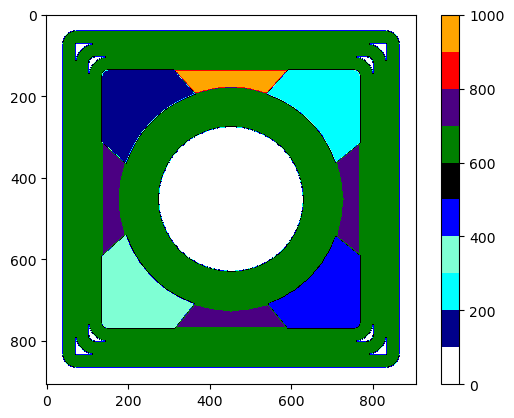

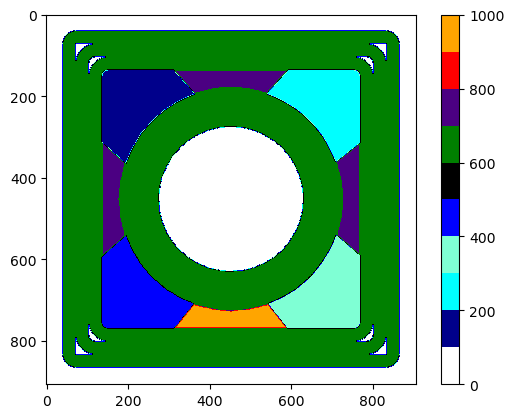

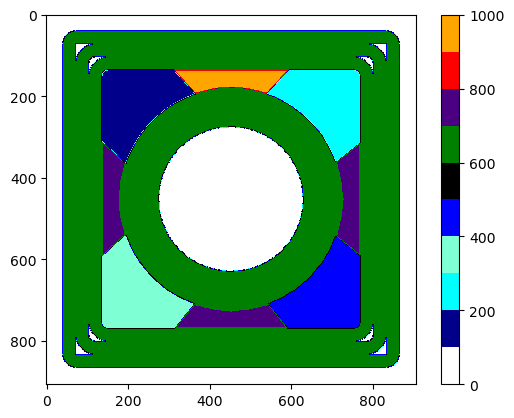

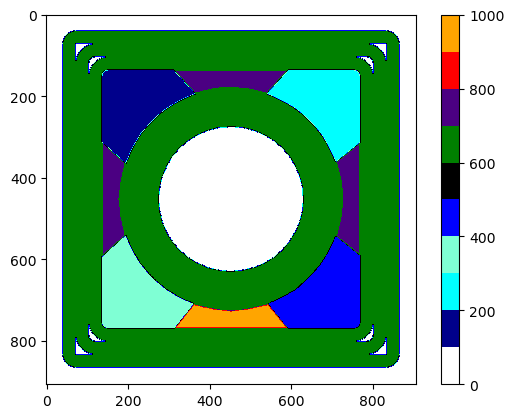

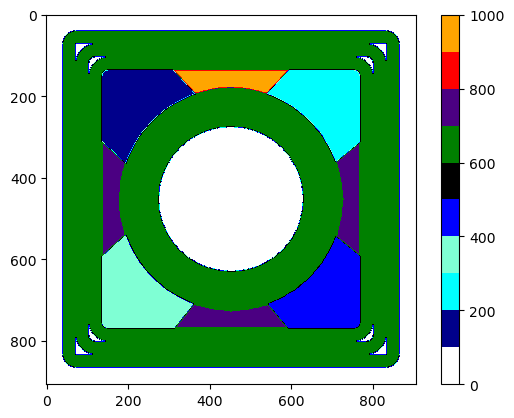

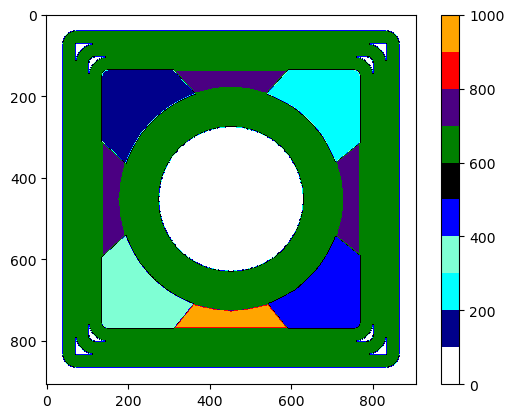

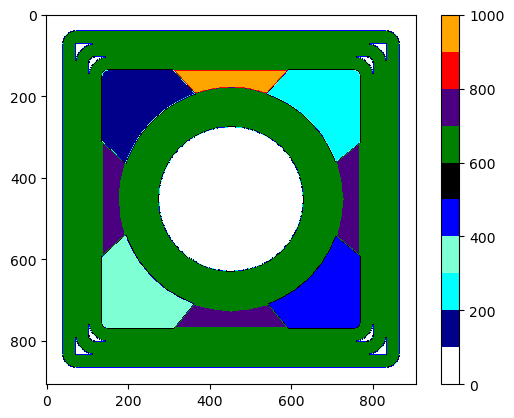

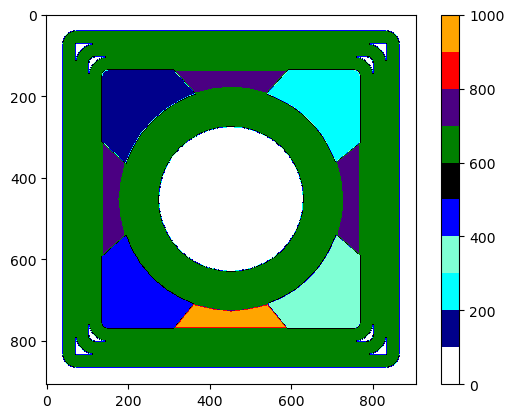

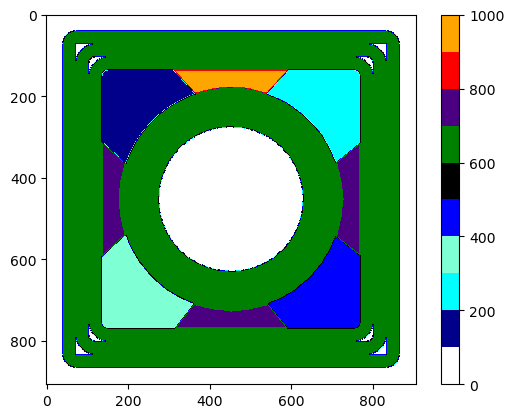

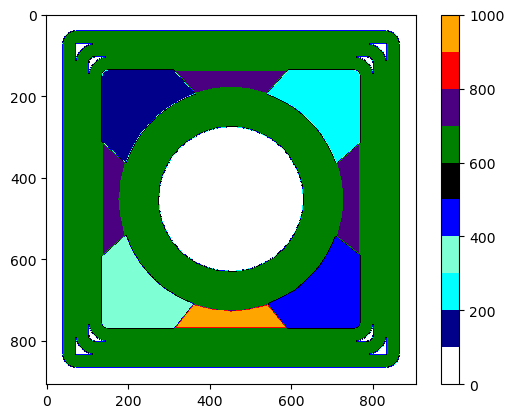

In [46]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [47]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.09036612510681152
Total de [Making offset routes] : 2.314992904663086
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.07231807708740234
Total de [Making offset routes] : 2.2204251289367676
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.12497663497924805
Total de [Making offset routes] : 2.4118363857269287
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.09899616241455078
Total de [Making offset routes] : 2.434767723083496
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.09627556800842285
Total de [Making offset routes] : 2.3903751373291016
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.1202695369720459
Total de [Making offset routes] : 2.3222782611846924
Making offset routes
salvando imagens

Rotas de pontes

In [48]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making bridges routes"):
        c.make_bridges_routes(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.21853232383728027
Total de [Making bridges routes] : 11.12430191040039
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.2214517593383789
Total de [Making bridges routes] : 10.759335041046143
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.22202157974243164
Total de [Making bridges routes] : 11.410515546798706
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.21363115310668945
Total de [Making bridges routes] : 10.74350118637085
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.21817755699157715
Total de [Making bridges routes] : 12.18234920501709
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.220930814743042
Total de [Making bridges routes] : 11.263224363327026
Making bridges routes
salvan

Rotas de Ziguezague

In [49]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 6.238792896270752
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.19544529914855957
fazendo as tres opções:
Total de [fazendo as tres opções:] : 6.006033420562744
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.17872071266174316
fazendo as tres opções:
Total de [fazendo as tres opções:] : 5.970702171325684
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.18117952346801758
fazendo as tres opções:
Total de [fazendo as tres opções:] : 6.020207643508911
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.18038368225097656
Total de [criando as rotas de zigzag, camada:L_000] : 26.742337226867676
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.14609193801879883
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.09862637519836426
Conectando regiões de zigzag
Total de [Conectando regiõ

In [50]:
#WEAVING

import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] : 0.6478214263916016
Achando os contatos
Total de [Achando os contatos] : 1.4707248210906982
criando os weavings
Total de [criando os weavings] : 0.5142421722412109
Total de [gerando preenchimentos oscilatórios] : 4.459978103637695
salvando rotas
Total de [salvando rotas] : 0.19635868072509766
Total de [Fase 5 b] : 4.658190965652466
Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] : 0.6053073406219482
Achando os contatos
Total de [Achando os contatos] : 2.0523245334625244
criando os weavings
Total de [criando os weavings] : 0.4661722183227539
Total de [gerando preenchimentos oscilatórios] : 5.228619575500488
salvando rotas
Total de [salvando rotas] : 0.14843535423278809
Total de [Fase 5 b] : 5.379458665847778
Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] 

Rotas de Thin Walls

In [51]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 5.054473876953125e-05
Total de [Making thin walls routes] : 0.026398658752441406
Total de [Fase 5] : 0.02661299705505371
Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 4.935264587402344e-05
Total de [Making thin walls routes] : 0.025081157684326172
Total de [Fase 5] : 0.02516913414001465
Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 4.506111145019531e-05
Total de [Making thin walls routes] : 0.025715351104736328
Total de [Fase 5] : 0.025776386260986328
Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 5.054473876953125e-05
Total de [Making thin walls routes] : 0.025550127029418945
Total de [Fase 5] : 0.02560901641845703
Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 4.673004150390625e-0

Unificando rotas EXTERNAS nas camadas

In [52]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Encontrando ponto de união ext-int
33
34
Total de [Encontrando ponto de união ext-int] : 0.20863676071166992
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.36998534202575684
Conectando pontes de Crossover
salto:  [209, 534]
Total de [Conectando pontes de Crossover] : 1.9691345691680908
Total de [Conectando rotas externas] : 2.9731953144073486
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.37561559677124023
Total de [Fase 6] : 3.349989652633667
Fase 6
Conectando rotas externas
Encontrando ponto de união ext-int
33
34
Total de [Encontrando ponto de união ext-int] : 0.19466567039489746
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.24355244636535645
Conectando pontes de Crossover
salto:  [698, 374]
Total de [Conectando pontes de Crossover] : 2.1874752044677734
Total de [Conectando rotas externas] : 3.0019311904907227
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.41

Unificando rotas INTERNAS nas camadas

In [53]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 4.406996726989746
Conectando pontes de zigzag
salto:  [580, 169]
salto:  [739, 581]
salto:  [327, 738]
Total de [Conectando pontes de zigzag] : 1.5456547737121582
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.2063891887664795
Total de [Fase 7] : 6.502852916717529
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 4.541140079498291
Conectando pontes de zigzag
salto:  [581, 170]
salto:  [169, 580]
salto:  [580, 740]
Total de [Conectando pontes de zigzag] : 1.3391823768615723
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.15126705169677734
Total de [Fase 7] : 6.392917156219482
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 4.539606809616089
Conectando pontes de zigzag
salto:  [580, 169]
salto:  [739, 581]
salto:  [327, 738]
Total de [Conectando pontes de zigzag] : 1.5148863792419434
salvando imagens das rotas
Total de [sal

Unindo rotas de thin walls

In [54]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0009853839874267578
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.06513452529907227
Total de [Fase 8] : 0.09278035163879395
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0005071163177490234
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.06270837783813477
Total de [Fase 8] : 0.08978867530822754
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0009791851043701172
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.06827306747436523
Total de [Fase 8] : 0.09652519226074219
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0005238056182861328
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.06296253204345703
Total de [Fase 8] : 0.0956571102142334
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0005300045013427734
salvando imagens das ro

Unindo todas as rotas e criando codigo G

In [1]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall] = gui.ask_parameters_Gcode()
camadas = folders.load_layers_hdf5()

internal_trees = []
external_trees = []
tw_trees = []
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        
for c in camadas:
    c.close_final_path(folders)
    for isl in c.islands:
        internal_trees.append([list(x) for x in isl.internal_tree_route.sequence])
        external_trees.append([list(x) for x in isl.external_tree_route.sequence])
        tw_trees.append([list(x) for x in isl.thinwalls_tree_route.sequence])

with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_thin_wall, 
                               internal_trees,
                               external_trees,
                               tw_trees,
                               )
%reset_selective -f "camadas"

Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.009584903717041016
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.010933637619018555
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.010791301727294922
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.01228785514831543
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.02649521827697754
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.01297760009765625
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.013294696807861328
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.014557838439941406
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.01734161376953125
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.012396097183227539
layer rotacionada
Cuspindo o Gcode
trocou para 1
tro

In [56]:
import numpy as np
camadas = folders.load_layers_hdf5()
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
        print(internal_trees)
print([235,807] in internal_trees)

[[154, 258], [154, 257], [154, 256], [154, 255], [154, 254], [154, 253], [154, 252], [154, 251], [154, 250], [154, 249], [154, 248], [154, 247], [154, 246], [154, 245], [154, 244], [154, 243], [154, 242], [154, 241], [154, 240], [154, 239], [154, 238], [154, 237], [154, 236], [154, 235], [154, 234], [154, 233], [154, 232], [154, 231], [154, 230], [154, 229], [154, 228], [154, 227], [154, 226], [154, 225], [154, 224], [154, 223], [154, 222], [154, 221], [154, 220], [154, 219], [154, 218], [154, 217], [154, 216], [154, 215], [154, 214], [154, 213], [154, 212], [154, 211], [154, 210], [154, 209], [154, 208], [154, 207], [154, 206], [154, 205], [154, 204], [154, 203], [154, 202], [154, 201], [154, 200], [154, 199], [154, 198], [154, 197], [154, 196], [154, 195], [154, 194], [154, 193], [154, 192], [154, 191], [154, 190], [154, 189], [154, 188], [154, 187], [154, 186], [154, 185], [154, 184], [154, 183], [154, 182], [154, 181], [154, 180], [154, 179], [154, 178], [154, 177], [154, 176], [15

In [57]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [58]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)